<a href="https://colab.research.google.com/github/albertometelli/rl-phd-2022/blob/main/03_gpomdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# G(PO)MDP

This notebook is inspired to the Stable Baselines3 tutorial available at [https://github.com/araffin/rl-tutorial-jnrr19](https://github.com/araffin/rl-tutorial-jnrr19).


## Introduction

In this notebook, we will implement a very basic version of **G(PO)MDP**.

### Links

Open AI Gym Github: [https://github.com/openai/gym](https://github.com/openai/gym)

Open AI Gym Documentation: [https://www.gymlibrary.ml](https://www.gymlibrary.ml)

Stable Baselines 3 Github:[https://github.com/DLR-RM/stable-baselines3](https://github.com/DLR-RM/stable-baselines3)

Stable Baseline 3 Documentation: [https://stable-baselines3.readthedocs.io/en/master/](https://stable-baselines3.readthedocs.io/en/master/)

## Install Dependencies and Stable Baselines3 Using Pip

In [ ]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra]

In [1]:
import stable_baselines3
stable_baselines3.__version__

'1.4.0'

## Video Recording

In Google Colab it is not possible to render the Gym environments, so we need to record a video and then reproduce it. Here are the helper functions. 

In [2]:
# Set up fake display; otherwise rendering will fail
import os
import base64
from pathlib import Path
from IPython import display as ipythondisplay
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

def show_videos(video_path='', prefix=''):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                    </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id)])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs[0])
        obs, _, _, _ = eval_env.step([action])

    # Close the video recorder
    eval_env.close()

    
def render(env_id, policy, video_length=500, prefix='', video_folder='videos/'):
    record_video(env_id, policy, video_length, prefix, video_folder)
    show_videos(video_folder, prefix)

## Evaluation

A helper function to evaluate policies.

In [3]:
def evaluate(env, policy, gamma=1., num_episodes=100):
    """
    Evaluate a RL agent
    :param env: (Env object) the Gym environment
    :param policy: (BasePolicy object) the policy in stable_baselines3
    :param gamma: (float) the discount factor
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    discounter = 1.
    all_episode_rewards = []
    for i in range(num_episodes): # iterate over the episodes
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done: # iterate over the steps until termination
            action, _ = policy.predict(obs)
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward * discounter) # compute discounted reward
            discounter *= gamma

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    std_episode_reward = np.std(all_episode_rewards) / np.sqrt(num_episodes - 1)
    print("Mean reward:", mean_episode_reward, 
          "Std reward:", std_episode_reward,
          "Num episodes:", num_episodes)

    return mean_episode_reward, std_episode_reward

## Plotting

A helper function to plot the learning curves.

In [4]:
import matplotlib.pyplot as plt


def plot_results(results):
    plt.figure()
    
    _mean = []
    _std = []
    for m, s in results:
        _mean.append(m)
        _std.append(s)
        
    _mean = np.array(_mean)
    _std = np.array(_std)
        
    ts = np.arange(len(_mean))
    plt.plot(ts, _mean, label='G(PO)MDP')
    plt.fill_between(ts, _mean-_std, _mean+_std, alpha=.2)
        
    plt.xlabel('Trajectories')
    plt.ylabel('Average return')
    plt.legend(loc='lower right')
    
    plt.show()

## G(PO)MDP

![ss](gpomdp.png)

**References**

Baxter, Jonathan, and Peter L. Bartlett. "Infinite-horizon policy-gradient estimation." Journal of Artificial Intelligence Research 15 (2001): 319-350.

## Policy

We will use a Gaussian policy, linear in the state variables and with fixed (non-learnable) standard deviation. 

$$
\pi_{\boldsymbol{\theta}}(a|\mathbf{s}) = \mathcal{N}(a| \boldsymbol{\theta}^T \mathbf{s}, \sigma^2)
$$

The policy must implement the usual `predict` method and some additional methods for computing the policy gradient. Specifically, we will need a `grad_log` method to return the gradient of the logarithm of the policy (the score):

$$
\nabla_{\boldsymbol{\theta}} \log \pi_{\boldsymbol{\theta}}(a|\mathbf{s})= \frac{(a - \boldsymbol{\theta}^T \mathbf{s})\mathbf{s}}{\sigma^2}
$$

## Exercise 1

Complete the implementation of the methods `predict` and `grad_log`

In [5]:
class GaussianPolicy:
    
    def __init__(self, dim, std=0.1):
        """
        :param dim: number of state variables
        :param std: fixed standard deviation
        """
        
        self.std = std
        self.dim = dim
        self.theta = np.zeros((dim,))  # zero initializatoin
    
    def get_theta(self):
        return self.theta
    
    def set_theta(self, value):
        self.theta = value
    
    def predict(self, obs):
        """
        :param obs: (ndarray) the state observation (dim,)
        :return: the sampled action and the same observation
        """
        action = 0.
        
        #TODO
        
        return np.array([action]), obs
    
    def grad_log(self, obs, action):
        """
        :param obs: (ndarray) the state observation (dim,)
        :param action: (float) the action
        :return: (ndarray) the score of the policy (dim,)
        """
        grad_log = 0.
        
        #TODO
        
        return grad_log

## Exercise 1 - Solution

In [6]:
class GaussianPolicy:
    
    def __init__(self, dim, std=0.1):
        """
        :param dim: number of state variables
        :param std: fixed standard deviation
        """
        
        self.std = std
        self.dim = dim
        self.theta = np.zeros((dim,))  # zero initializatoin
    
    def get_theta(self):
        return self.theta
    
    def set_theta(self, value):
        self.theta = value
    
    def predict(self, obs):
        mean = np.dot(obs, self.theta)
        action = mean + np.random.randn() * self.std
        return np.array([action]), obs
    
    def grad_log(self, obs, action):
        mean = np.dot(obs, self.theta)
        grad_log = (action - mean) * obs / self.std ** 2
        return grad_log

## Training Routine

We provide the already implemented skeleton of the training routine that samples at every iterations $m$ trajectories from the environment.

In [7]:
def collect_rollouts(env, policy, m, T):
    """
    Collects m rollouts by running the policy in the
        environment
    :param env: (Env object) the Gym environment
    :param policy: (Policy object) the policy
    :param gamma: (float) the discount factor
    :param m: (int) number of episodes per iterations
    :param K: (int) maximum number of iterations
    :param theta0: (ndarray) initial parameters (d,)
    :param alpha: (float) the constant learning rate
    :param T: (int) the trajectory horizon
    :return: (list of lists) one list per episode
                each containing triples (s, a, r)
    """
    
    ll = []
    for j in range(m):
        s = env.reset()
        t = 0
        done = False
        l = []
        while t < T and not done:
            a, _ = policy.predict(s)
            s1, r, done, _ = env.step(a)
            l.append((s, a, r))
            s = s1
            t += 1
        ll.append(l)
    return ll
            
def train(env, policy, gamma, m, K, alpha, T):
    """
    Train a policy with G(PO)MDP
    :param env: (Env object) the Gym environment
    :param policy: (Policy object) the policy
    :param gamma: (float) the discount factor
    :param m: (int) number of episodes per iterations
    :param K: (int) maximum number of iterations
    :param alpha: (float) the constant learning rate
    :param T: (int) the trajectory horizon
    :return: list (ndarray, ndarray) the evaluations
    """
    
    results = []
    
    # Evaluate the initial policy
    res = evaluate(env, policy, gamma)
    results.append(res)
    
    for k in range(K):
        
        print('Iteration:', k)
        
        # Generate rollouts
        rollouts = collect_rollouts(env, policy, m, T)
        
        # Get policy parameter
        theta = policy.get_theta()
        
        # Call your G(PO)MDP estimator
        pg = gpomdp(rollouts, policy, gamma)
        
        # Update policy parameter
        theta = theta + alpha * pg
        
        # Set policy parameters
        policy.set_theta(theta)
        
        # Evaluate the updated policy
        res = evaluate(env, policy, gamma)
        results.append(res)
    
    return results

## Exercise 2

Complete the following function `gpomdp` that computes the G(PO)MDP gradient estimator given rollout trajectories.

In [8]:
def gpomdp(rollouts, policy, gamma):
    """
    :param rollouts: (list of lists) generated by 'collect_rollouts'
    :param policy: (Policy object) the policy
    :param gamma: (float) the discount factor
    :return: (ndarray) the policy gradient (dim,)
    """
    
    grad = 0
    
    #TODO

    return grad

## Exercise 2 - Solution

The following is a possible implementation of G(PO)MDP that turns out to be very inefficient! It can be improved by precomputing the scores at the beginning and using matrix opertions instead of for cicles.

In [9]:
def gpomdp_inefficient(rollouts, policy, gamma):
    
    grad = 0
    
    # Very very inefficient implementation!
    for roll in rollouts:
        H = len(roll)
        
        sum_rew = 0.
        for t in range(H):
            
            sum_scores = 0.
            for l in range(t + 1):
                s, a, _ = roll[l]
                score = policy.grad_log(s, a)
                sum_scores += score
            
            _, _, r = roll[t]
            sum_rew += gamma ** t * r * sum_scores
        
        grad += sum_rew
    
    return grad / len(rollouts)   

We can speedup the implementation, by precomputing the cumulative sum of the scores.

In [10]:
def gpomdp(rollouts, policy, gamma):
    
    grad = 0
    
    # A little more efficient implementation!
    for roll in rollouts:
        H = len(roll)
        disc_rew = np.zeros((H, 1))
        scores = np.zeros((H, policy.dim))
        
        for t in range(H):
            s, a, r = roll[t]
            disc_rew[t] = gamma ** t * r
            scores[t] = policy.grad_log(s, a)
        
        cum_scores = np.cumsum(scores, axis=0)
        
        grad += np.sum(cum_scores * disc_rew, axis=0)
        

    return grad / len(rollouts)   

## Test our Implementation

We test our G(PO)MDP implementation over the `MountainCarContinuous-v0` environment.

MountainCarContinuous Environment Decription: [https://gym.openai.com/envs/MountainCarContinuous-v0/](https://gym.openai.com/envs/MountainCarContinuous-v0/)

MountainCarContinuous Source Code: [https://github.com/openai/gym/blob/master/gym/envs/classic_control/continuous_mountain_car.py](https://github.com/openai/gym/blob/master/gym/envs/classic_control/continuous_mountain_car.py)

We consider a modified simpler version

In [11]:
import gym
from gym.envs.classic_control.continuous_mountain_car import Continuous_MountainCarEnv
from gym.envs.registration import register


class SimplifiedContinuous_MountainCarEnv(Continuous_MountainCarEnv):
    
    def __init__(self, goal_velocity=0):
        super(SimplifiedContinuous_MountainCarEnv, self).__init__(goal_velocity)
        
        # We make the environment a little bit simpler by increasing the power
        self.power =  0.02


# Just in case you re-run the code
if "SimplifiedMountainCarContinuous-v1" in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs["SimplifiedMountainCarContinuous-v1"]

register(
    id="SimplifiedMountainCarContinuous-v1",
    entry_point="__main__:SimplifiedContinuous_MountainCarEnv",
    max_episode_steps=200,
    reward_threshold=100,
)

In [12]:
import gym
import numpy as np


# Instantiate the environment
env = gym.make('SimplifiedMountainCarContinuous-v1')

# Instantiate the policy
policy = GaussianPolicy(env.observation_space.shape[0], std=0.2)

gamma = 0.999  # discount factor
m = 100        # number of trajectories per iteration
K = 100        # maximum number of iterations
alpha = 0.001  # learning rate
T = 200        # lenght of each trajectory

# Start training
results = train(env, policy, gamma, m, K, alpha, T)

0.02
Mean reward: 2.0552311827521637 Std reward: 0.9416761182876752 Num episodes: 100
Iteration: 0
Mean reward: 4.271323083553066 Std reward: 1.4864793658015865 Num episodes: 100
Iteration: 1
Mean reward: 3.1459445612082386 Std reward: 1.2795568446454881 Num episodes: 100
Iteration: 2
Mean reward: 5.045528581040107 Std reward: 1.6043137797862728 Num episodes: 100
Iteration: 3
Mean reward: 5.440629287343516 Std reward: 1.720966084808933 Num episodes: 100
Iteration: 4
Mean reward: 3.586772335261963 Std reward: 1.3093528272401602 Num episodes: 100
Iteration: 5
Mean reward: 4.7915424421985415 Std reward: 1.5025932476934327 Num episodes: 100
Iteration: 6
Mean reward: 6.558353760824808 Std reward: 1.6040414540885346 Num episodes: 100
Iteration: 7
Mean reward: 7.323729734701946 Std reward: 1.8125759749447512 Num episodes: 100
Iteration: 8
Mean reward: 2.9377679750097583 Std reward: 1.1991573902887296 Num episodes: 100
Iteration: 9
Mean reward: 9.57107538108782 Std reward: 2.0997611094589037 N

Mean reward: 9.126634018861758 Std reward: 1.9316795305101113 Num episodes: 100
Iteration: 89
Mean reward: 11.655145387375747 Std reward: 2.195260425643456 Num episodes: 100
Iteration: 90
Mean reward: 10.093504624732201 Std reward: 1.8604825058288201 Num episodes: 100
Iteration: 91
Mean reward: 9.068496970092609 Std reward: 1.9662277851412564 Num episodes: 100
Iteration: 92
Mean reward: 11.571361965572027 Std reward: 2.016002445130432 Num episodes: 100
Iteration: 93
Mean reward: 14.610802778749408 Std reward: 2.346142243461094 Num episodes: 100
Iteration: 94
Mean reward: 10.37721810980994 Std reward: 2.1018438222827833 Num episodes: 100
Iteration: 95
Mean reward: 8.67973222702646 Std reward: 1.874529018106504 Num episodes: 100
Iteration: 96
Mean reward: 3.920988988782975 Std reward: 1.3871703040750267 Num episodes: 100
Iteration: 97
Mean reward: 19.267762281087588 Std reward: 2.2949252883443205 Num episodes: 100
Iteration: 98
Mean reward: 20.921112127204374 Std reward: 2.27727085902983

Let us render the results.

In [13]:
render('SimplifiedMountainCarContinuous-v1', policy, prefix='gpomdp')
evaluate(env, policy)

Saving video to /home/alberto/rl-phd-2022/videos/gpomdp-step-0-to-step-500.mp4


Mean reward: 98.51949771765591 Std reward: 1.0061103858116716 Num episodes: 100


(98.51949771765591, 1.0061103858116716)

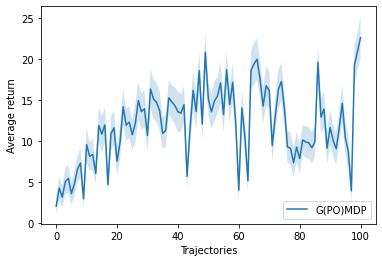

In [14]:
plot_results(results)